# The oect_processing package
### A Guide to using this package for processing OECT data
### Rajiv Giridharagopal, University of Washington (rgiri@uw.edu)

This notebook introduces the OECT package and how to process OECT data. For further information, documentation can be found online (eventually!). In the meantime, this package will go through some of the basics.

The **oect** package allows you to do the following:

* Extract transfer and output curves from text files
* Generate a uC* plot from several devices, assuming you have the dimensions saved in a config file
* Allows easy plotting of threshold voltage calculation, transfer curves, transconductance, output curves
* Enables easy saving of the device data 

It essentially uses two Python Class objects
1) an **OECT** Class for processing a single dataset (a particular channel, say)

2) an **OECTDevice** Class for processing a folder of many devices. 

There is an oect_utils directory containing plotting, loading, and some helper functions

In [1]:
# You may need to run this cell twice if there's a "relative import" error 

import os, sys
#os.chdir(r'..')
base_dir = '\\'.join(os.getcwd().split('\\')[:-1])
sys.path.append(base_dir)
import oect_processing
from oect_processing.oect_utils import oect_plot

test_data = base_dir + r'\notebooks\test_data'
device_01 = base_dir + r'\notebooks\test_data\02'

## Basic processing of a single device pixel (a single transistor)

#### Using the OECT class on single devices (scroll down below to process a series of folders at once)

The basic unit of this package is the OECT class. The cell below shows the docstring.

The general usage is:
```
dv = oect_processing.OECT(path_to_folder_with_data)
dv.calc_gms()
dv.thresh()
```
That series of commands processes a particular folder with transfer and output curves. It generates the transconductance (*gm*) via ```calc_gms()``` and the threshold voltage via ```thresh()```. 
The data are saved in the class as Pandas DataFrames. If that means nothing to you, that's okay! It's a broadly used package for handling data, and it makes plotting and manipulating pretty simple.

The OECT class takes a few other inputs.

For example:

1) Explicitly provide the device volume factors width (W), length (L), thickness (d)

```
dv = oect.OECT(path_to_folder_with_data, params={'W': 100e-6, 'L': 20e-6, 'd': 100e-9})
```

2) Average forward and reverse traces

```
dv = oect.OECT(path_to_folder_with_data, params={'W': 100e-6, 'L': 20e-6, 'd': 100e-9}, options={'Average': True})
```

See the docstring for more detail. But the OECT Class will contain many attributes, the most important being:

* ```outputs``` : DataFrame
        Single DataFrame of all outputs in one file.
        Assumes all data taken on same Vd range (as during an experiment)
* ```transfers``` : DataFrame
        Single dataFrame with all transfer curves
* ```gms``` : DataFrame
        Transconductance for all sweeps (in Siemens) as one DataFrame
* ```Vts``` : ndarray
        Threshold voltage for forward and reverse trace
        Element 0: forward, 1: reverse
* ```WdL``` : float
        The value of W*d/L, d=thickness, W=width, L=length of the device


In [2]:
# Execute this cell to view docstring for OECT class
oect_processing.OECT?

In [3]:
# Process out example device
try:
    dv = oect_processing.OECT(device_01)
except: # Correct for MacOS
    base_dir = '/'.join(os.getcwd().split('/')[:-1])
    sys.path.append(base_dir)
    test_data = base_dir + '/notebooks/test_data'
    device_01 = base_dir + '/notebooks/test_data/02'
    device_01 = base_dir + '/notebooks/test_data/02'
    
    
# Print the transfer DataFrame for demonstration
print('\n===========')
print('This is the Transfer curve DataFrame, dv.transfers\nThe Columns indicate "forward" and "backward/reverse" traces, but')
print('the numbering is arbitrary. It just means there are two transfer curves in this folder.')
print('The data are in their raw form (presumably Amps), the index (left column) is the Vgs Voltage')
print('===========')
print(dv.transfers)

C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_output_1.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_transfer_0.txt

This is the Transfer curve DataFrame, dv.transfers
The Columns indicate "forward" and "backward/reverse" traces, but
the numbering is arbitrary. It just means there are two transfer curves in this folder.
The data are in their raw form (presumably Amps), the index (left column) is the Vgs Voltage
           -0.6_0_01     -0.6_0_02
-0.900 -2.075404e-03 -1.306442e-03
-0.875 -1.248910e-03 -1.399366e-03
-0.850 -1.071051e-03 -9.959191e-04
-0.825 -9.006365e-04 -8.420766e-04
-0.800 -7.387336e-04 -6.927613e-04
-0.775 -5.872797e-04 -5.495662e-04
-0.750 -4.490298e-04 -4.171035e-04
-0.725 -3.249849e-04 -2.981577e-04
-0.700 -2.191461e-04 -3.933

In [4]:
# Print the Output DataFrame for demonstration
print('\n===========')
print('This is the Output curve DataFrame, dv.outputs')
print('The Columns indicate "forward" and "backward/reverse" traces for each Gate Voltage')
print('===========')
print(dv.outputs)


This is the Output curve DataFrame, dv.outputs
The Columns indicate "forward" and "backward/reverse" traces for each Gate Voltage
          -0.5_fwd      -0.5_bwd  -0.8_fwd  -0.8_bwd
-0.7 -9.176301e-07 -8.926868e-07 -0.001071 -0.000651
-0.6 -2.469988e-07 -2.677639e-07 -0.000655 -0.000648
-0.5  3.612016e-07  3.153517e-07 -0.000646 -0.000645
-0.4  1.000468e-06  9.704653e-07 -0.000642 -0.000641
-0.3  1.720908e-06  1.633080e-06 -0.000635 -0.000635
-0.2  2.335257e-06  2.306844e-06 -0.000595 -0.000630
-0.1  3.013899e-06  2.990748e-06 -0.000389 -0.000437
-0.0  3.725951e-06  3.725951e-06  0.000004  0.000004


In [5]:
# Calculate the transconductance

dv.calc_gms()

# Print the Transconductance DataFrame for demonstration
print('\n==================================================')
print('This is the gms (Transconductance) DataFrame, dv.gms')
print('====================================================')
print(dv.gms)

       peak gm (S)
-0.90     0.046032
-0.85     0.011146

This is the gms (Transconductance) DataFrame, dv.gms
           gm_-0.6_0     gm_-0.6_1
-0.900  4.603246e-02 -1.364438e-02
-0.875  2.008706e-02  6.210458e-03
-0.850  6.965470e-03  1.114579e-02
-0.825  6.646348e-03  6.063156e-03
-0.800  6.267136e-03  5.850208e-03
-0.775  5.794076e-03  5.513156e-03
-0.750  5.245896e-03  5.028170e-03
-0.725  4.597674e-03  4.754800e-04
-0.700  3.820258e-03  2.651194e-03
-0.675  2.953340e-03  6.672594e-03
-0.650  2.041640e-03  1.850406e-03
-0.625  1.203493e-03  1.034314e-03
-0.600  5.741576e-04  1.418403e-03
-0.575  2.082784e-04  1.529444e-04
-0.550  5.496450e-05  4.144819e-05
-0.525  1.006311e-05  5.174593e-06
-0.500  8.825840e-07 -1.323950e-07
-0.475 -7.704660e-07 -1.084873e-06
-0.450 -1.531868e-06 -1.530980e-06
-0.425 -1.545722e-06 -1.586350e-06
-0.400 -1.605004e-06 -1.770814e-06
-0.375 -1.666698e-06 -1.991222e-06
-0.350 -1.511042e-06 -1.972986e-06
-0.325 -1.326706e-06 -2.035304e-06
-0.300 -1.5405

This shows how the threshold voltage is calculated, with the legend corresponding to forward and reverse
(ignore the symbols in the legend, I have not fixed that bug. The numbers are correct)
This array contains the Vt data, dv.Vts
[-0.58286941 -0.5638332 ]


C:\Users\Raj\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


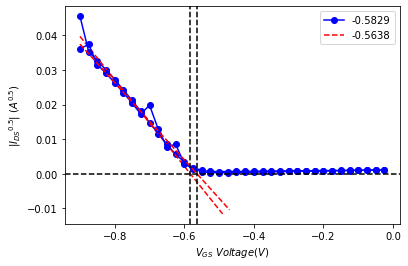

In [6]:
# Calculate the Threshold Voltage

print('This shows how the threshold voltage is calculated, with the legend corresponding to forward and reverse')
print('(ignore the symbols in the legend, I have not fixed that bug. The numbers are correct)')
dv.thresh(plot=True)

print ('This array contains the Vt data, dv.Vts')
print(dv.Vts)

### Plot the results

Now that we have a single device pixel, ```dv```, we can use the plotting functions in oect.oect_utils.oect_plot to show them! See the code there for more details. You can of course plot the data directly via the DataFrames above. For example, the backwards transfer column is accessed directly by ```dv.transfers['0.6_0_01']```

In our example here, we can see that one of the transfer curves is pretty bad. We might consider retaking that data, or we could just plot the specific transfer column directly.

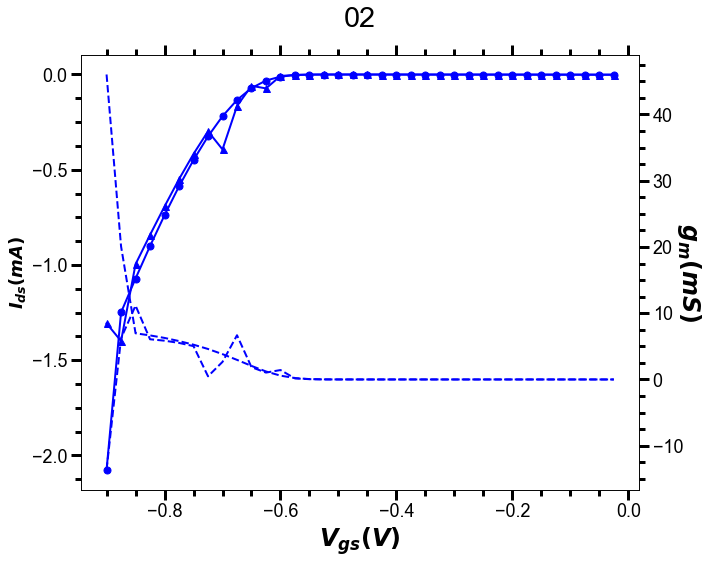

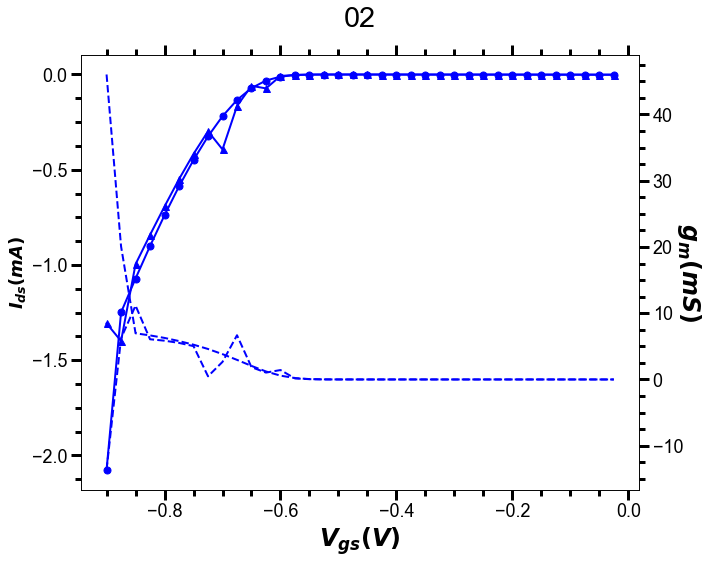

In [7]:
# Plot the transfer curves
oect_plot.plot_transfers_gm(dv)

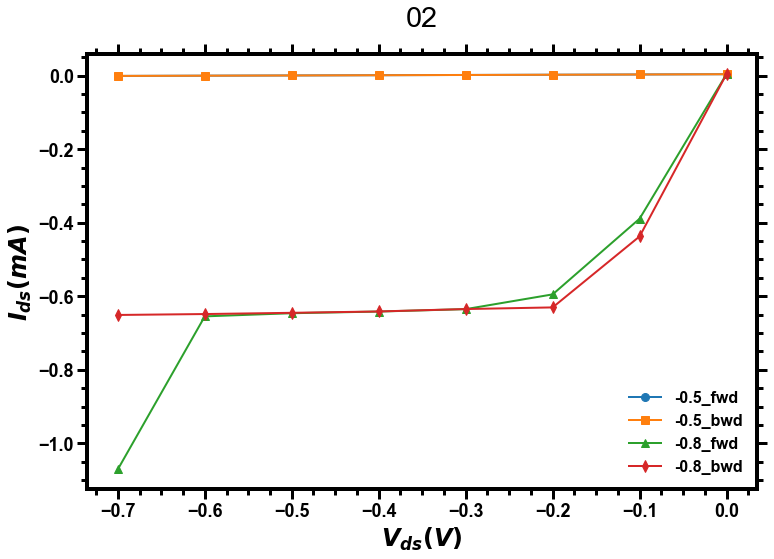

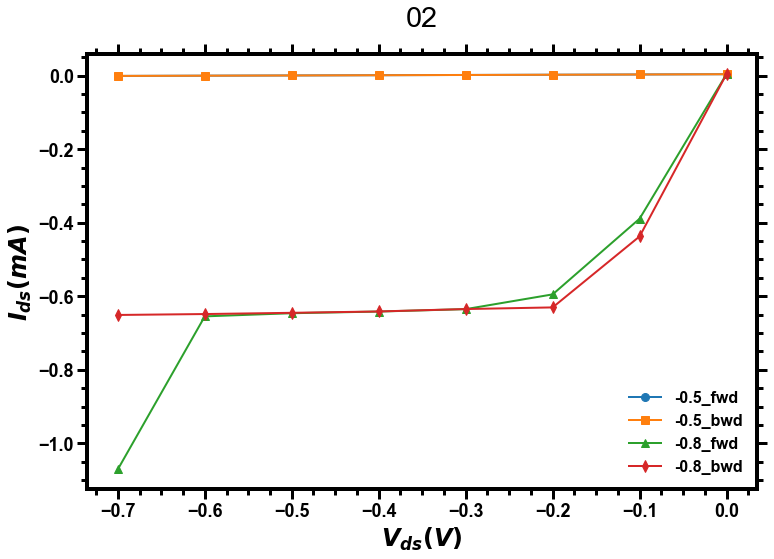

In [8]:
oect_plot.plot_outputs(dv)

## Processing a Device with many Pixels (generating uC*)

#### Using the OECTDevice class on folder of devices

For this to work, your data must be arranged such that the subfolders are numbers.
I use 01, 02, 03, etc for my subfolder names. Each folder then contains data like that used for a single pixel.

To process these data together, we can use the OECTDevice class. This class is considerably less developed, but in general this will process all your data, optionally save all the figures for you, and produce uC* data. It will also save the associated data in a dictionary, where each pixel is processed using the methods described above.

### The easiest usage for this package is to process all the data with OECTDevice 

Here's how it works, assuming your parent folder is test_data/01, test_data/02, etc..Each folder should have a config file with the correct Width/Length/thickness or this will not generate the correct numbers. The OECT class can generate a config file automatically.

In a future version you can supply this directly.

```
device = oect_processing.OECTDevice('path_to_test_data')
```

That's it! The default is to save the uC* plots at the end, but not all the transfer and output curves along the way. There are lots of things you can change though:

1) Save all the curves (transfer and output). Note that this can crash with too much data, matplotlib is not memory-efficient.

```
device = oect_processing.OECTDevice('path_to_test_data', options={'plot': [True, True]}) #[Show all curves, Show uC* plot]
```

2) Only process the Retrace

```
device = oect_processing.OECTDevice('path_to_test_data', options={'retrace_only': True})
```

3) Minimize command-line printing

```
device = oect_processing.OECTDevice('path_to_test_data', options={'verbose': False})
```

You can of course combine those as you wish. The end result is an object of OECTDevice class, and it has many attributes. Here are a **few** of them

*   ```WdL``` : array
        W*d/L (prefactor in gm equation) for each device
*   ```Vg_Vt``` : array
        Vg - Vt value for each device (gate voltage of peak gm minus threshold votlage)
*   ```Vt``` : array
        Threshold voltage
* ```uC``` : float
        uC* extracted from the gm vs WdL * Vg_Vt plot
* ```gms``` : array
        peak transconductances for each device
* ```pix_paths``` : array
        Folder paths for the pixels
* ```pixels``` : dictionary
        Dictionary of the generated pixels using OECT class for each folder

In [9]:
# View the docstring for OECTDevice
oect_processing.OECTDevice?

In [10]:
device = oect_processing.OECTDevice(test_data, options={'plot': [False, False]}) # No plotting to save memory

{}
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\01\uc1_4000um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\01\uc1_4000um_kpf6_output_1.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\01\uc1_4000um_kpf6_transfer_0.txt
       peak gm (S)
-0.90     0.099433
-0.75     0.020937
{}
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_output_1.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\02\uc2_1000um_kpf6_transfer_0.txt
       peak gm (S)
-0.90     0.046032
-0.85     0.011146
{}


C:\Users\Raj\Anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Raj\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C

C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\03\uc3_400um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\03\uc3_400um_kpf6_output_1.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\03\uc3_400um_kpf6_transfer_0.txt
      peak gm (S)
-0.9     0.025857
-0.7     0.003518
{}
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\04\uc6_800um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\04\uc6_800um_kpf6_output_1.txt
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\04\uc6_800um_kpf6_transfer_0.txt
        peak gm (S)
-0.900     0.049343
-0.725     0.006590
{}
C:\Users\Raj\Documents\Coding\oect\oect_processing\oect_processing\notebooks\test_data\05\uc5_2000um_kpf6_output_0.txt
C:\Users\Raj\Documents\Coding\oect\oect_processin

C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Raj\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


uC* = [282.21804345] F/cm*V*s


[<AxesSubplot:title={'center':'uC* = [282.21804345] F/cm*V*s'}, xlabel='Wd/L * (Vg-Vt) (cm*V)', ylabel='gm (mS)'>,
 <AxesSubplot:title={'center':'$\\mu$$C*$ = [282.22] F/cm*V*s'}, xlabel='$Wd/L * (Vg-Vt) (cm*V)$', ylabel='$g_m (mS)$'>,
 <Figure size 648x432 with 1 Axes>]

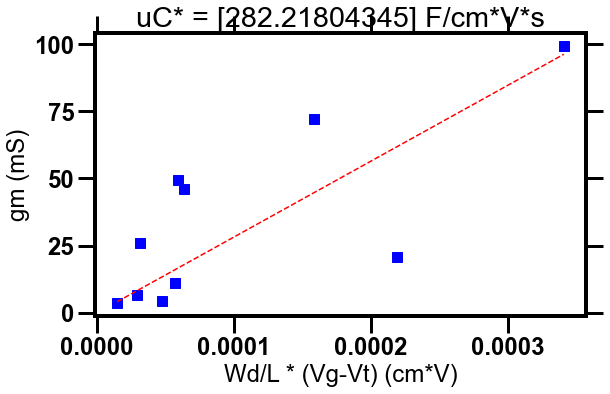

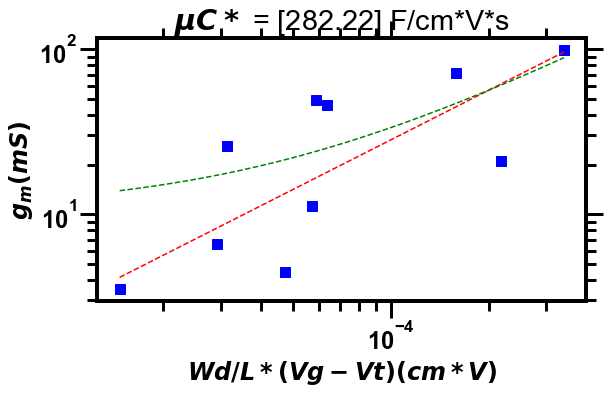

In [11]:
# Plot the uC*
oect_plot.plot_uC(device)

uC* = [282.21804345] F/cm*V*s


[<AxesSubplot:title={'center':'uC* = [282.21804345] F/cm*V*s'}, xlabel='Wd/L * (Vg-Vt) (cm*V)', ylabel='gm (mS)'>,
 <AxesSubplot:title={'center':'$\\mu$$C*$ = [282.22] F/cm*V*s'}, xlabel='$Wd/L * (Vg-Vt) (cm*V)$', ylabel='$g_m (mS)$'>,
 <Figure size 648x432 with 1 Axes>]

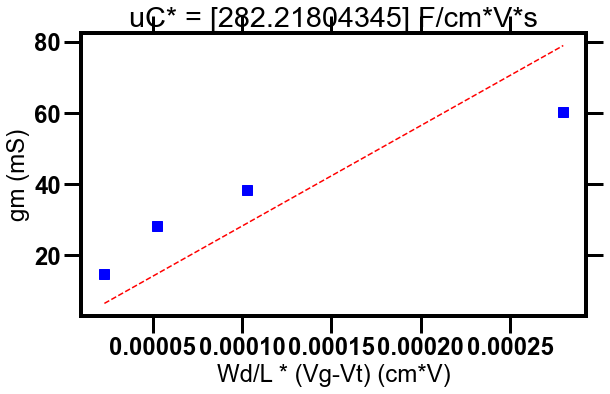

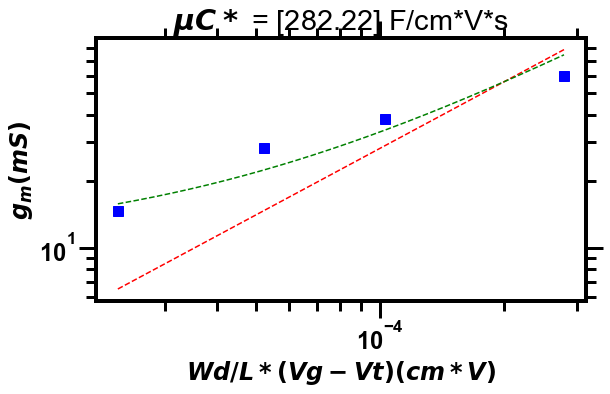

In [12]:
# Plot the uC*, but average the forward/reverse data for each devce
oect_plot.plot_uC(device, average=True)